
# Financial News Sentiment Classification — End‑to‑End Project

**Author:** Teng Zhang  
**Last updated:** 2025-11-12 10:16 UTC

This notebook performs an end-to-end workflow to classify sentiment (positive / neutral / negative) of financial news headlines/sentences.

**What you'll find:**
1. **Data Collection**: Load Financial PhraseBank and optionally **scrape recent headlines** (Yahoo Finance / EastMoney).
2. **Cleaning & Preprocessing**: lowercase, punctuation removal, stopword removal, lemmatization.
3. **Exploratory Data Analysis (EDA)**: class balance, word frequency, word cloud, key terms.
4. **Modeling** (3+ models):
   - **Multinomial Naive Bayes** (TF‑IDF features)
   - **BiLSTM** (pretrained embeddings or randomly initialized)
   - **Transformer fine‑tuning** (FinBERT or DistilBERT baseline)
5. **Evaluation**: accuracy, precision/recall/F1, confusion matrix; compare models.
6. **Application**: apply the best model to **unseen** scraped/manual headlines and interpret predictions.

> **Scoring focus**: clarity and depth of data prep, EDA, and model selection rationale. Model performance supports your narrative.



## 0. Setup
Install packages (one-time). If you're in a restricted environment, consider running only classical models (NB+TF‑IDF) first.


In [28]:

# If running locally, uncomment as needed (may take time for Transformers).
# %pip install -q numpy pandas scikit-learn matplotlib wordcloud nltk beautifulsoup4 requests lxml
# %pip install -q tensorflow==2.* gensim
# %pip install -q transformers datasets torch --extra-index-url https://download.pytorch.org/whl/cpu


## 1. Imports & Utilities

In [29]:

import os, re, json, math, random, string, time, warnings, itertools, collections
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings("ignore")

# Ensure NLTK data is available locally; download missing resources to a writable path
NLTK_DIR = str(Path("./nltk_data").resolve())
os.makedirs(NLTK_DIR, exist_ok=True)
# Ensure both runtime path and environment variable are set so all NLTK calls see it
if NLTK_DIR not in nltk.data.path:
    nltk.data.path.insert(0, NLTK_DIR)
os.environ["NLTK_DATA"] = NLTK_DIR

# If zipped corpora exist locally, extract them into expected directories
try:
    import zipfile
    to_extract = [
        (Path(NLTK_DIR) / "corpora" / "wordnet.zip", Path(NLTK_DIR) / "corpora" / "wordnet"),
        (Path(NLTK_DIR) / "corpora" / "omw-1.4.zip", Path(NLTK_DIR) / "corpora" / "omw-1.4"),
        (Path(NLTK_DIR) / "corpora" / "stopwords.zip", Path(NLTK_DIR) / "corpora" / "stopwords"),
        (Path(NLTK_DIR) / "tokenizers" / "punkt.zip", Path(NLTK_DIR) / "tokenizers" / "punkt"),
    ]
    for zpath, dstdir in to_extract:
        if zpath.exists() and not dstdir.exists():
            dstdir.parent.mkdir(parents=True, exist_ok=True)
            with zipfile.ZipFile(str(zpath), "r") as zf:
                zf.extractall(str(dstdir.parent))
except Exception:
    pass

resources = [
    ("corpora/stopwords", "stopwords"),
    ("corpora/wordnet", "wordnet"),
    ("tokenizers/punkt", "punkt"),
    ("corpora/omw-1.4", "omw-1.4"),  # optional but useful for WordNet
]

def ensure_local(key: str, pkg: str) -> None:
    try:
        p = nltk.data.find(key)
        if not str(p).startswith(NLTK_DIR + os.sep):
            # present elsewhere; also place a copy under local NLTK_DIR
            nltk.download(pkg, download_dir=NLTK_DIR, quiet=True)
            nltk.data.find(key)  # re-check
    except LookupError:
        ok = nltk.download(pkg, download_dir=NLTK_DIR, quiet=True)
        if not ok:
            raise RuntimeError(f"Failed to download NLTK package: {pkg}")

for res_key, pkg in resources:
    ensure_local(res_key, pkg)
# Optional report:
# print({pkg: str(nltk.data.find(key)) for key, pkg in resources})

EN_STOP = set(stopwords.words("english"))
LEMM = WordNetLemmatizer()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR = Path("./outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)



## 2. Data Collection
### 2.1 Load Financial PhraseBank (baseline)
Use Local CSV: put `financial_phrasebank.csv` into `./data/`


In [30]:

# Local dataset loading only — headerless CSV assumed
local_csv = DATA_DIR / "all-data.csv"
if not local_csv.exists():
    raise FileNotFoundError(
        "Dataset not found at ./data/all-data.csv. "
        "Expected two columns: label,text (no header)."
    )

# Read with fixed encoding (detected as cp1252), headerless; auto-detect delimiter
tmp = pd.read_csv(local_csv, encoding="cp1252", header=None, sep=None, engine="python")
if tmp.shape[1] < 2:
    raise ValueError("Expected at least two columns (label,text) in all-data.csv")

df_base = tmp.iloc[:, :2]
df_base.columns = ["label", "text"]

df_base = df_base.dropna(subset=["text", "label"]).reset_index(drop=True)
df_base.head()


,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...



### 2.2 Scrape recent headlines
Fetch recent headlines via Google News RSS (no JS). This may break if providers change; if it fails, the cell will skip gracefully.


In [31]:

import requests

def scrape_google_news_ticker(ticker="AAPL", max_items=50, days=7, lang="en-US", region="US"):
    """
    Fetch recent headlines via Google News RSS.
    Returns DataFrame with columns [source, ticker, title, url].
    """
    from urllib.parse import quote_plus
    from xml.etree import ElementTree as ET

    query = f"{ticker} stock"
    lang_short = lang.split("-")[0] if "-" in lang else lang
    hl = lang
    gl = region
    ceid = f"{region}:{lang_short}"
    feed_url = (
        f"https://news.google.com/rss/search?q={quote_plus(query)}+when:{days}d"
        f"&hl={hl}&gl={gl}&ceid={ceid}"
    )

    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(feed_url, headers=headers, timeout=15)
    r.raise_for_status()

    items = []
    root = ET.fromstring(r.text)
    for it in root.findall(".//item"):
        title = (it.findtext("title") or "").strip()
        link = (it.findtext("link") or "").strip()
        if title and len(title.split()) > 2:
            items.append({"source": "google_news", "ticker": ticker, "title": title, "url": link})
        if len(items) >= max_items:
            break
    return pd.DataFrame(items).drop_duplicates(subset=["title"])


DF_SCRAPE = pd.DataFrame()
try:
    df_y_aapl = scrape_google_news_ticker("AAPL", max_items=30)
    DF_SCRAPE = pd.concat([DF_SCRAPE, df_y_aapl], ignore_index=True)
except Exception as e:
    print("Google News RSS scrape skipped:", e)

print(f"Scraped rows: {len(DF_SCRAPE)}")
if len(DF_SCRAPE):
    DF_SCRAPE.to_csv(OUT_DIR / "scraped_headlines.csv", index=False, encoding="utf-8")
DF_SCRAPE.head()


Scraped rows: 30


,source,ticker,title,url
0,google_news,AAPL,What Will Drive Apple Stock’s Next Big Move? -...,https://news.google.com/rss/articles/CBMiowFBV...
1,google_news,AAPL,"After Earnings, Is Apple Stock a Buy, a Sell, ...",https://news.google.com/rss/articles/CBMilwFBV...
2,google_news,AAPL,A Look at Apple (AAPL) Valuation After Recent ...,https://news.google.com/rss/articles/CBMivAFBV...
3,google_news,AAPL,What Could Spark the Apple Stock's Next Big Mo...,https://news.google.com/rss/articles/CBMiugFBV...
4,google_news,AAPL,Can Apple Shares Surge Past $300 This Year? - ...,https://news.google.com/rss/articles/CBMijgFBV...



## 3. Cleaning & Preprocessing
This step creates a cleaned text column (`text_clean`) for classical and RNN models, while keeping the original `text` for Transformer models.

- NLTK path restriction
  - Restrict NLTK to the local directory `./nltk_data` (no system paths, no network downloads).

- Basic normalization (`basic_clean`)
  - Lowercase all text.
  - Normalize whitespace (collapse repeats; remove tabs/newlines).
  - Keep alphanumerics and finance‑relevant symbols: `- $ % . , ! ? '`. Remove other characters.
  - Example: "According to Gran, the company has NO plans to..." → "according to gran, the company has no plans to..."

- Tokenization (offline, no `punkt`)
  - Use `TreebankWordTokenizer` to split words; works offline without extra models.

- Stopword removal
  - Remove common English stopwords via NLTK (e.g., "the", "and", "to").
  - If you want to keep negations, subtract them from the list (e.g., `{"not", "no", "never"}`).

- Lemmatization
  - Use `WordNetLemmatizer` (e.g., "companies" → "company").
  - Requires local corpora `wordnet` and `omw-1.4` under `./nltk_data/corpora/`.

- Outputs
  - `df["text_clean"]`: cleaned + tokenized + stopword‑removed + lemmatized text.
  - `label_set`, `label2id`, `id2label`: label mappings.
  - `df["label_id"]`: numeric labels for training.
  - Build TF‑IDF (1–2‑gram; `min_df=3`; `max_df=0.95`) and compute class‑contrast n‑gram scores (per class vs. others) for use in EDA Top‑K tables and wordclouds.

- Downstream usage
  - TF‑IDF+NB and BiLSTM use `text_clean`.
  - Transformers use the original `text` with their own tokenizer.


In [32]:

# Force NLTK to use only local nltk_data under project root
import os as _os
from pathlib import Path as _Path
import nltk as _nltk
_NLTK_DATA_DIR = str(_Path("./nltk_data").resolve())
_os.environ["NLTK_DATA"] = _NLTK_DATA_DIR
_nltk.data.path = [_NLTK_DATA_DIR]

custom_fin_stops = {
    # 报道体&通用
    "said","say","says","according","announced","report","today","yesterday",
    "company","group","corp","ltd","inc","oyj","plc","co","sa","ab","ag",
    "business","unit","subsidiary","division","board","management",

    # 货币/单位/数值
    "eur","usd","cny","jpy","gbp","mn","mln","billion","million","percent","per","share",
    "__NUM__",  # 若做数值归一则加入
    "q1","q2","q3","q4","first","second","third","fourth","half","nine","month","months","year","years",

    # 地名/国别（可按语料调整）
    "finnish","finland","helsinki","swedish","europe","russia","china",

    # 其它常见名词
    "market","sale","services","service","product","solution","technology","project",
    "contract","agreement","deal","order","customer","share","price",

    "__num__","period","corresponding","quarter","net"
}

# Merge provided custom_fin_stops into EN_STOP
try:
    EN_STOP = EN_STOP.union(set(custom_fin_stops))
except Exception:
    pass


def normalize_num_currency(text: str):
    t = re.sub(r"\b\d+([.,]\d+)?\b", "__NUM__", text)
    t = re.sub(r"\b(eur|usd|cny|jpy|gbp)\b", r"\1", t)
    return t

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"[\t\n\r]", " ", t)
    t = re.sub(r"[^a-z0-9\s\-\$%.,!?']", " ", t)
    return t.strip()

def tokenize_lemmatize(text: str):
    # Ensure local NLTK path is recognized even if setup cell wasn't run just now
    import nltk
    from nltk.tokenize import TreebankWordTokenizer
    from pathlib import Path as _Path
    _nlp_dir = str(_Path("./nltk_data").resolve())
    if _nlp_dir not in nltk.data.path:
        nltk.data.path.insert(0, _nlp_dir)
    tok = TreebankWordTokenizer()
    words = tok.tokenize(text)
    words = [LEMM.lemmatize(w) for w in words if w not in EN_STOP and w not in string.punctuation]
    return " ".join(words)

df = df_base.copy()

# 固定搭配映射（提前定义，保证后续清洗可用）
COLLOCATION_MAP = {
    r"\bnet profit\b": "net_profit",
    r"\boperating profit\b": "operating_profit",
    r"\bprofit rose\b": "profit_rose",
    r"\bprofit increased\b": "profit_increased",
    r"\bprofit warning\b": "profit_warning",
    r"\braised guidance\b": "raised_guidance",
    r"\bcut guidance\b": "cut_guidance",
    r"\bmissed estimates?\b": "missed_estimates",
    r"\bbeat estimates?\b": "beat_estimates",
    r"\bupgraded? to buy\b": "upgrade_to_buy",
    r"\bdowngraded? to\b": "downgraded_to",
    r"\bloss narrowed\b": "loss_narrowed",
    r"\bnet loss\b": "net_loss",
    r"\boperating loss\b": "operating_loss",
    r"\bhigher than expected\b": "higher_than_expected",
    r"\blower than expected\b": "lower_than_expected",
}

# 在停用词去除与词形还原之前进行“多词合并”为单 token（用下划线连接）
try:
    _COL_MAP = COLLOCATION_MAP
except NameError:
    _COL_MAP = {}

def merge_collocations_text(text: str):
    t = text
    for pat, repl in _COL_MAP.items():
        t = re.sub(pat, repl, t)
    return t

df["text_clean"] = (
    df["text"]
        .apply(basic_clean)
        .apply(normalize_num_currency)
        .apply(merge_collocations_text)  # 先合并固定搭配
        .apply(tokenize_lemmatize)       # 再做停用词去除 + 词形还原
)

label_set = sorted(df["label"].unique().tolist())
label2id = {lab:i for i,lab in enumerate(label_set)}
id2label = {i:lab for lab,i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

print("Labels:", label2id)
df.head()

# TF-IDF (1–2gram) features + class-contrast scores (non-visual)
stops = set(custom_fin_stops)
vec12 = TfidfVectorizer(
    ngram_range=(1,2), min_df=3, max_df=0.95,
    stop_words=list(stops)
)
X12 = vec12.fit_transform(df["text_clean"])  

def class_contrast_scores(label_name, X, vec):
    idx_pos = (df["label"]==label_name).values
    mean_pos = X[idx_pos].mean(axis=0).A1
    mean_oth = X[~idx_pos].mean(axis=0).A1
    score = mean_pos - mean_oth
    return pd.Series(score, index=vec.get_feature_names_out()).sort_values(ascending=False)

neg_feat12 = class_contrast_scores("negative", X12, vec12)
neu_feat12 = class_contrast_scores("neutral",  X12, vec12)
pos_feat12 = class_contrast_scores("positive", X12, vec12)

# TF-IDF (2gram) features + class-contrast scores
vec22 = TfidfVectorizer(
    ngram_range=(2,2), min_df=3, max_df=0.95,
    stop_words=list(stops)
)
X22 = vec22.fit_transform(df["text_clean"])

neg_feat22 = class_contrast_scores("negative", X22, vec22)
neu_feat22 = class_contrast_scores("neutral",  X22, vec22)
pos_feat22 = class_contrast_scores("positive", X22, vec22)


Labels: {'negative': 0, 'neutral': 1, 'positive': 2}


## 4. Exploratory Data Analysis (EDA)

- Class distribution and text length histograms.
- TF‑IDF class‑contrast n‑gram analysis (1–2‑gram; `min_df=3`; `max_df=0.95`):
  - Visuals currently show unigrams only (bigrams filtered for clarity).
  - Show Top‑K n‑grams per class ranked by contrast score (class vs. others).
  - Wordclouds weighted by contrast scores (negative scores clipped to 0).

Note: earlier raw "Top words" tables and bag‑of‑words wordclouds were removed; EDA now focuses on TF‑IDF contrast signals.

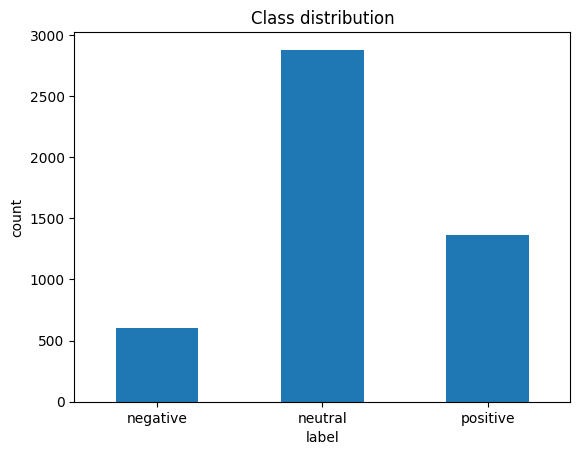

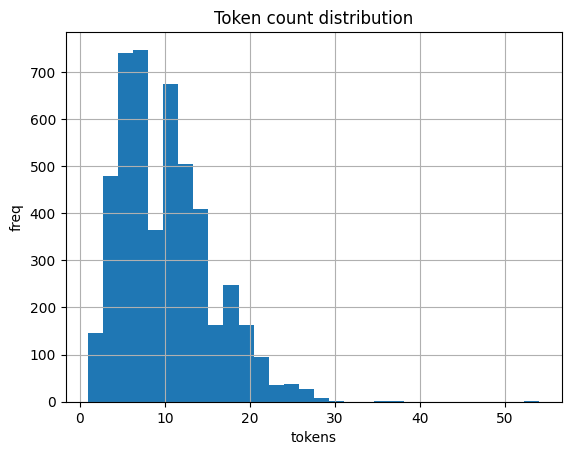

Top 20 — negative (1-2gram)


,ngram,score
0,decreased,0.038696
1,fell,0.028293
2,compared,0.024835
3,profit,0.023329
4,operating_profit,0.019943
5,operating_loss,0.014906
6,totalled,0.013954
7,lower,0.012314
8,loss,0.012289
9,result,0.011634



Top 20 — neutral (1-2gram)


,ngram,score
0,value,0.009226
1,approximately,0.006494
2,total,0.005327
3,development,0.005065
4,disclosed,0.004801
5,right,0.004708
6,includes,0.004644
7,part,0.004355
8,stake,0.004341
9,capital,0.003981



Top 20 — positive (1-2gram)


,ngram,score
0,rose,0.021223
1,increased,0.017737
2,operating_profit,0.017289
3,increase,0.013939
4,operating_profit rose,0.009578
5,grew,0.009039
6,compared,0.008281
7,signed,0.007851
8,growth,0.007718
9,improved,0.006730



Top 20 — negative (2gram)


,ngram,score
0,compared profit,0.017652
1,operating_profit fell,0.015998
2,operating_profit decreased,0.015396
3,earnings eps,0.010045
4,lay offs,0.009945
5,recurring item,0.009864
6,totalled compared,0.009453
7,non recurring,0.009324
8,temporary lay,0.009158
9,operating_loss totalled,0.008492



Top 20 — neutral (2gram)


,ngram,score
0,alma medium,0.005335
1,voting right,0.005072
2,financial detail,0.004388
3,total value,0.003761
4,stock option,0.003696
5,square metre,0.003512
6,also includes,0.003496
7,alexandria va,0.003403
8,general meeting,0.003325
9,real estate,0.002844



Top 20 — positive (2gram)


,ngram,score
0,operating_profit rose,0.014237
1,operating_profit increased,0.007934
2,net_profit rose,0.006901
3,long term,0.006699
4,increased respectively,0.006242
5,cash flow,0.004637
6,cost saving,0.004627
7,compared loss,0.004316
8,expected increase,0.004264
9,adp news,0.004109


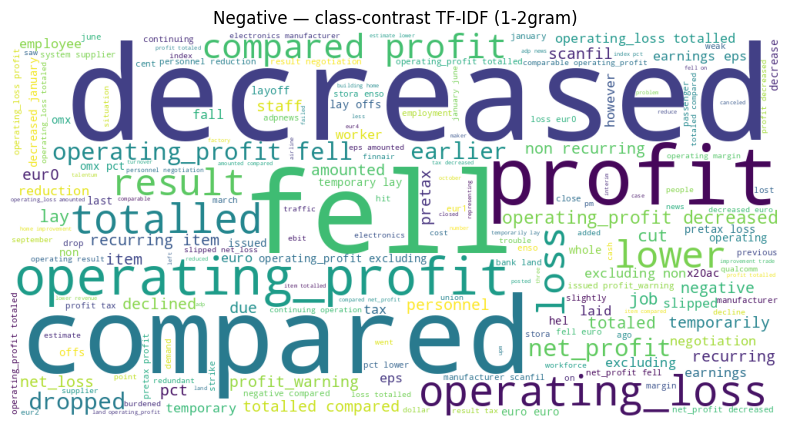

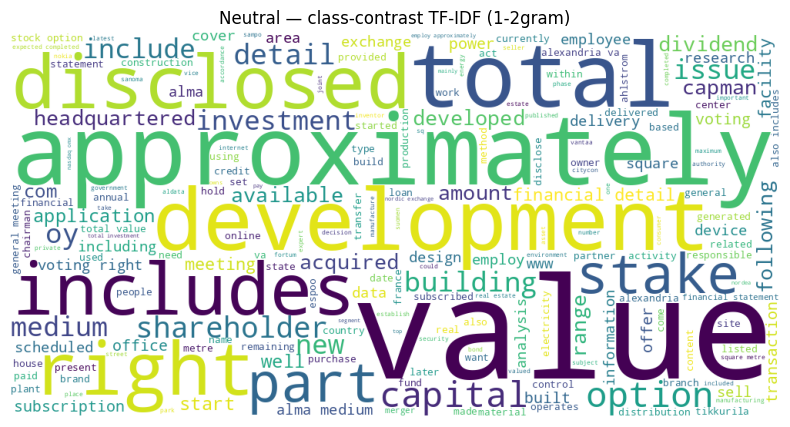

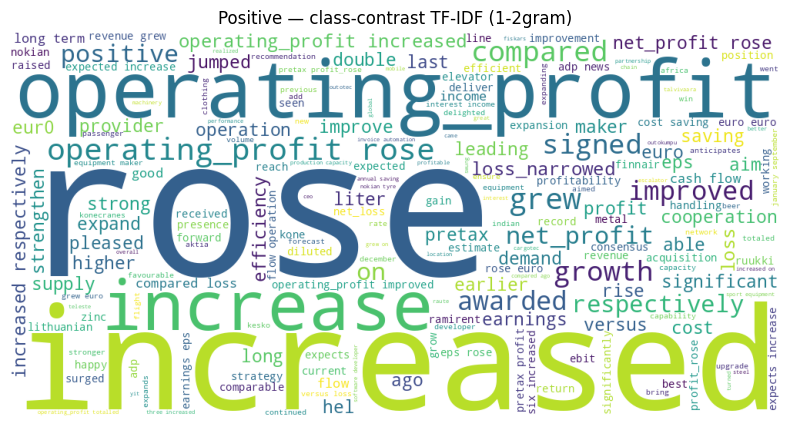

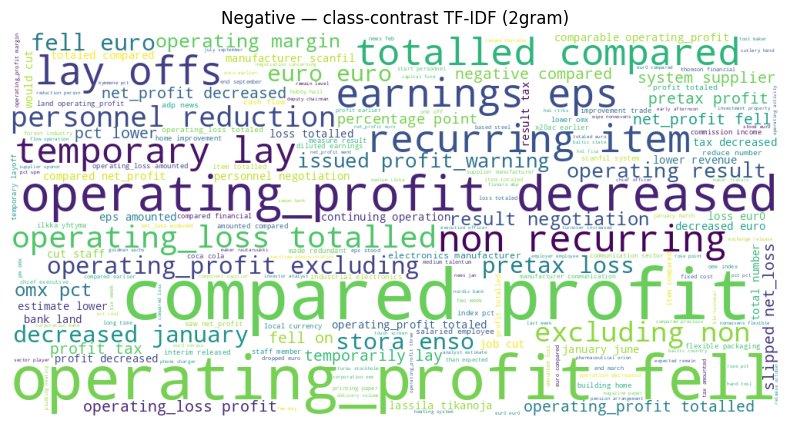

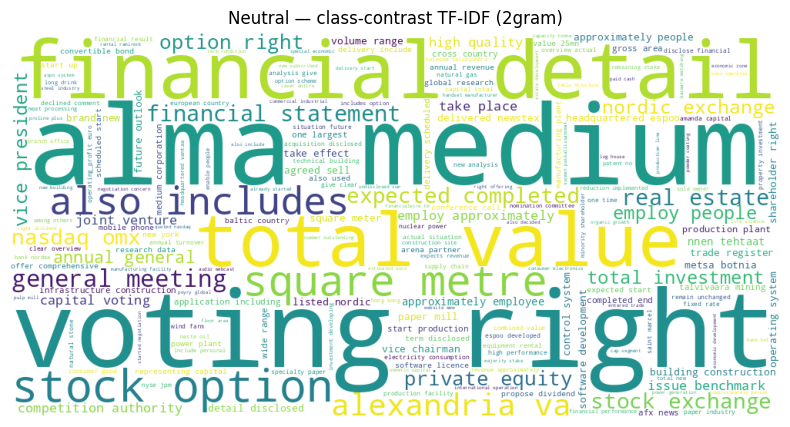

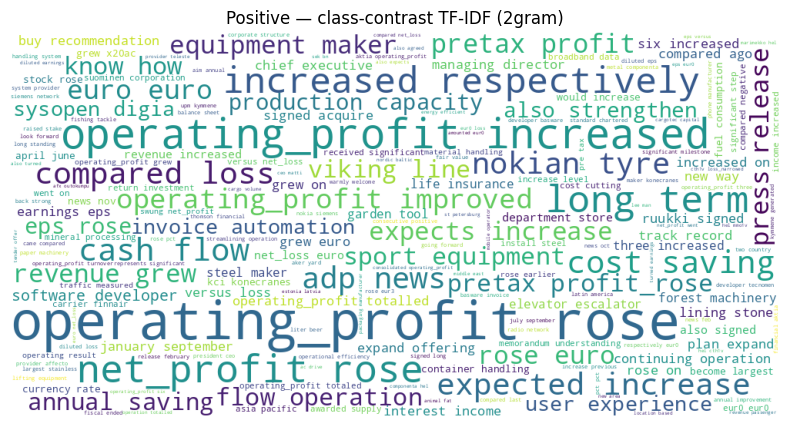

In [33]:

# Class balance
counts = df["label"].value_counts().sort_index()
ax = counts.plot(kind="bar", rot=0, title="Class distribution")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

# Lengths
df["n_tokens"] = df["text_clean"].str.split().apply(len)
df["n_chars"] = df["text"].str.len()

plt.figure()
df["n_tokens"].hist(bins=30)
plt.title("Token count distribution")
plt.xlabel("tokens")
plt.ylabel("freq")
plt.show()

# Class-contrast TF-IDF (1-2gram) — top-K tables

def display_top_k(series, label, k=20):
    df_top = series.head(k).rename_axis('ngram').reset_index(name='score')
    with pd.option_context('display.max_colwidth', None, 'display.max_rows', k):
        print(f"Top {k} — {label}")
        display(df_top)
        print()

# Use precomputed neg_feat12/neu_feat12/pos_feat12 from cleaning cell
display_top_k(neg_feat12, "negative (1-2gram)", 20)
display_top_k(neu_feat12,  "neutral (1-2gram)",  20)
display_top_k(pos_feat12,  "positive (1-2gram)", 20)

# 2-gram only (bigrams)
display_top_k(neg_feat22, "negative (2gram)", 20)
display_top_k(neu_feat22,  "neutral (2gram)",  20)
display_top_k(pos_feat22,  "positive (2gram)", 20)

# Class-contrast TF-IDF wordclouds (1-2gram)

def wc_from_scores(scores, title, k=200):
    import matplotlib.pyplot as plt
    vals = scores.clip(lower=0).head(k)
    wc = WordCloud(width=1000, height=500, background_color="white") \
         .generate_from_frequencies(vals.to_dict())
    plt.figure(figsize=(10,5)); plt.imshow(wc); plt.axis("off"); plt.title(title); plt.show()

wc_from_scores(neg_feat12, "Negative — class-contrast TF-IDF (1-2gram)")
wc_from_scores(neu_feat12,  "Neutral — class-contrast TF-IDF (1-2gram)")
wc_from_scores(pos_feat12,  "Positive — class-contrast TF-IDF (1-2gram)")

# 2-gram only wordclouds
wc_from_scores(neg_feat22, "Negative — class-contrast TF-IDF (2gram)")
wc_from_scores(neu_feat22,  "Neutral — class-contrast TF-IDF (2gram)")
wc_from_scores(pos_feat22,  "Positive — class-contrast TF-IDF (2gram)")


## 5. Train / Test Split

This section splits the dataset into training, validation, and test sets while preserving class proportions (stratified sampling).

- Step 1: Train/Test split (80% / 20%) from the full dataset `df`.
  - `test_size=0.2`: the test set is 20% and is used only once at the very end for an unbiased generalization estimate. It is not used for model choice or tuning.
  - `random_state=42`: fixed seed to make the split reproducible.
  - `stratify=df["label_id"]`: ensures each split maintains the original class distribution, reducing bias due to class imbalance.
- Step 2: Split the training portion again into Train/Validation (80% / 20%).
  - Validation set `val_df` is about 16% of the original data (0.8 × 0.2) and is used for model selection and hyperparameter tuning (e.g., TF‑IDF settings, NB alpha, etc.).
  - Training set `train_df` is about 64% of the original data and is used to fit the model parameters.

Overall proportions are approximately: Train 64% / Validation 16% / Test 20%.
The last line of this cell prints the shapes of the three splits so you can quickly verify the expected sizes.

In [34]:

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label_id"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label_id"])

print(train_df.shape, val_df.shape, test_df.shape)


(3100, 6) (776, 6) (970, 6)


## 6. Model 1 — Multinomial Naive Bayes (TF‑IDF)

Step-by-step: Multinomial Naive Bayes (TF‑IDF)

- Build the pipeline
  - TfidfVectorizer: ngram_range=(1, 2), min_df=3, max_df=0.95, sublinear_tf=True, norm="l2".
    - Why: keep both unigrams and bigrams; drop rare terms (<3 docs) and overly common terms (>95% docs); scale TF to 1+log(tf); L2-normalize vectors for comparability.
  - MultinomialNB(alpha=0.3): smoothing to avoid zero counts and improve generalization.

- Train (fit)
  - tfidf_nb.fit(train_df["text_clean"], train_df["label_id"]).
  - Learns TF‑IDF vocabulary/weights and NB parameters on the training split.

- Validate (predict + metrics)
  - pred_val = tfidf_nb.predict(val_df["text_clean"]).
  - Print accuracy + classification_report(..., target_names=label_set).
  - Under class imbalance, prefer macro‑F1 to judge balanced performance across classes.

- Bigram‑only comparison
  - Build tfidf_nb_2gram with ngram_range=(2, 2) (other params the same).
  - Fit and evaluate on the same validation data.
  - Purpose: show why keeping unigrams usually helps recall for positive/negative (many cues are single words like “downgrade/beat/miss”).

- What to tune next
  - alpha (e.g., 0.1–1.0), ngram_range, min_df/max_df; improve domain phrases upstream (merged tokens like profit_warning).
  - Need probabilities/thresholding? Use tfidf_nb.predict_proba(...) to adjust class thresholds.

- Outputs for later use
  - Trained pipelines: tfidf_nb (1–2g) and tfidf_nb_2gram (2g only) are reused in the final test evaluation and the demo application.


In [35]:

tfidf_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", MultinomialNB(alpha=0.3))
])

tfidf_nb.fit(train_df["text_clean"], train_df["label_id"])
pred_val = tfidf_nb.predict(val_df["text_clean"])
print("Validation — accuracy:", accuracy_score(val_df["label_id"], pred_val))
print(classification_report(val_df["label_id"], pred_val, target_names=label_set))

# NB (2-gram only) for comparison
tfidf_nb_2gram = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(2,2),
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", MultinomialNB(alpha=0.3))
])

tfidf_nb_2gram.fit(train_df["text_clean"], train_df["label_id"])
pred_val_2gram = tfidf_nb_2gram.predict(val_df["text_clean"])
print("Validation (2-gram) — accuracy:", accuracy_score(val_df["label_id"], pred_val_2gram))
print(classification_report(val_df["label_id"], pred_val_2gram, target_names=label_set))


Validation — accuracy: 0.7100515463917526
              precision    recall  f1-score   support

    negative       0.56      0.42      0.48        97
     neutral       0.75      0.90      0.81       461
    positive       0.65      0.44      0.52       218

    accuracy                           0.71       776
   macro avg       0.65      0.59      0.61       776
weighted avg       0.70      0.71      0.69       776

Validation (2-gram) — accuracy: 0.6417525773195877
              precision    recall  f1-score   support

    negative       0.44      0.19      0.26        97
     neutral       0.66      0.93      0.77       461
    positive       0.58      0.23      0.33       218

    accuracy                           0.64       776
   macro avg       0.56      0.45      0.45       776
weighted avg       0.61      0.64      0.59       776



### NB Validation Analysis (1–2gram vs 2-gram)

- Overall: The 1–2gram NB model clearly outperforms bigram-only. Accuracy 0.710 vs 0.642; Macro-F1 0.61 vs 0.45; Weighted-F1 0.69 vs 0.59. Including unigrams captures more sentiment cues and yields a better balance across classes.
- Class imbalance: Neutral dominates the validation set (support: neutral 461, positive 218, negative 97). High neutral recall (1–2gram 0.90; 2-gram 0.93) explains much of the accuracy, so macro-F1 is the better summary metric here.
- Minority classes: With 1–2gram, recall is 0.42 (negative) and 0.44 (positive); with 2-gram only, recall drops to 0.19 and 0.23. Bigram-only features miss many single-word sentiment signals (e.g., downgrade, miss, beat), leading to more neutral predictions.
- Error pattern: Many negative/positive examples are predicted as neutral. Precision is reasonable, but recall limits overall F1, especially for minority classes.
- Recommendation: Keep 1–2gram NB as the baseline; tune alpha (e.g., 0.1–1.0) and TF–IDF thresholds (min_df, max_df). 
- Next steps: Inspect confusion matrices and misclassified samples; build small domain lexicons (e.g., "profit_warning", "downgraded_to") to sanity-check errors and guide feature tweaks.


## 6a. Model 1b — Linear Models (TF‑IDF)
Train strong linear baselines on the same TF‑IDF settings as NB:
- Logistic Regression (OvR)
- LinearSVC

We report validation performance for comparison.


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Logistic Regression (OvR)
tfidf_logreg = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", LogisticRegression(C=1.0, max_iter=2000, solver="liblinear", multi_class="ovr", random_state=42))
])

tfidf_logreg.fit(train_df["text_clean"], train_df["label_id"])
logreg_val_pred = tfidf_logreg.predict(val_df["text_clean"])
print("LogReg Validation — accuracy:", accuracy_score(val_df["label_id"], logreg_val_pred))
print(classification_report(val_df["label_id"], logreg_val_pred, target_names=label_set))

# LinearSVC
tfidf_svc = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.95,
        sublinear_tf=True,
        norm="l2"
    )),
    ("clf", LinearSVC(C=1.0))
])

tfidf_svc.fit(train_df["text_clean"], train_df["label_id"])
svc_val_pred = tfidf_svc.predict(val_df["text_clean"])
print("LinearSVC Validation — accuracy:", accuracy_score(val_df["label_id"], svc_val_pred))
print(classification_report(val_df["label_id"], svc_val_pred, target_names=label_set))



LogReg Validation — accuracy: 0.6907216494845361
              precision    recall  f1-score   support

    negative       0.75      0.22      0.34        97
     neutral       0.69      0.96      0.80       461
    positive       0.66      0.34      0.45       218

    accuracy                           0.69       776
   macro avg       0.70      0.50      0.53       776
weighted avg       0.69      0.69      0.65       776

LinearSVC Validation — accuracy: 0.6984536082474226
              precision    recall  f1-score   support

    negative       0.56      0.41      0.48        97
     neutral       0.76      0.86      0.80       461
    positive       0.58      0.49      0.53       218

    accuracy                           0.70       776
   macro avg       0.63      0.59      0.60       776
weighted avg       0.68      0.70      0.69       776



### Linear Models Validation Analysis (LogReg vs LinearSVC)

- Overall: LinearSVC slightly outperforms Logistic Regression and nearly matches NB (1–2gram).
  - Accuracy: LinearSVC 0.700 > LogReg 0.691; NB was 0.710
  - Macro-F1: LinearSVC 0.60 > LogReg 0.53; NB was 0.61
  - Weighted-F1: LinearSVC 0.69 > LogReg 0.65; equal to NB 0.69
- Neutral class dominance: Both models lean on neutral to drive accuracy.
  - Neutral recall: LogReg 0.96 (very high), LinearSVC 0.86 (high)
- Minority classes (negative/positive):
  - LogReg: high precision but low recall (neg P=0.75/R=0.22, pos P=0.66/R=0.34) → many neg/pos misclassified as neutral
  - LinearSVC: better balance and higher recall (neg R=0.41, pos R=0.49) → improved per-class F1 (neg 0.48, pos 0.53)
- Error pattern: LogReg over-predicts neutral, sacrificing minority recall; LinearSVC reduces this bias and recovers more neg/pos cases.
- Recommendations:
  - Prefer LinearSVC when you need balanced class performance and higher recall on negative/positive.
  - If you prioritize avoiding false positives on minority classes, LogReg can work but tune thresholds.
  - LogReg: use predict_proba to tune decision thresholds; try class_weight="balanced", adjust C, optimize Fβ (β>1 for recall).
  - LinearSVC: tune C and class_weight="balanced"; use CalibratedClassifierCV to obtain probabilities and set class-specific thresholds.
  - Keep 1–2gram features; consider adjusting TF–IDF min_df/max_df and adding domain collocations; evaluate PR-AUC for negative/positive and inspect confusion matrices.


## 7. Model 2 — BiLSTM (Keras/TensorFlow)

Step-by-step: BiLSTM (Keras/TensorFlow)

- Prepare text → sequences
  - Tokenizer(num_words=20000, oov_token="<unk>") and fit on train_df["text_clean"].
  - Convert texts to integer ids and pad/truncate with pad_sequences(..., maxlen=40, padding="post", truncating="post").
  - Build X_tr, X_va and labels y_tr, y_va from label_id.

- Define the model
  - Embedding(input_dim=20000, output_dim=128, input_length=40): learnable word embeddings.
  - Bidirectional(LSTM(64, return_sequences=False)): captures left/right context; outputs a single vector.
  - Dropout(0.3): regularization to reduce overfitting.
  - Dense(num_labels, activation="softmax"): outputs class probabilities.

- Compile & train
  - optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"].
  - Train for epochs=3, batch_size=64 with validation_data=(X_va, y_va).
  - Optional: enable GPU memory growth to avoid full pre-allocation.

- Validate
  - preds = argmax(model.predict(X_va), axis=1).
  - Print accuracy and classification_report(..., target_names=label_set).

- What to tune next
  - MAX_VOCAB (10k–50k), MAX_LEN (40–64), embed dim (128–300), LSTM units (32–128), dropout (0.3–0.5), LR, epochs, batch size.
  - EarlyStopping(patience=1–2, restore_best_weights=True) and ModelCheckpoint to save the best model.
  - Handle imbalance: class_weight from sklearn.utils.class_weight or rebalancing; monitor macro‑F1/PR‑AUC for minority classes.
  - Try pretrained embeddings (GloVe/fastText) for better initialization.

- Outputs & reuse
  - Keep the trained model and tokenizer (tk) for test/evaluation.
  - Optionally save: model.save("outputs/bilstm_model.h5") and persist tk via joblib/pickle.

In [37]:

USE_BILSTM = True

if USE_BILSTM:
    try:
        import tensorflow as tf
        # Prevent TF from pre-allocating the entire GPU memory
        try:
            gpus = tf.config.experimental.list_physical_devices('GPU')
            for _g in gpus:
                tf.config.experimental.set_memory_growth(_g, True)
        except Exception:
            pass
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

        MAX_VOCAB = 20000
        MAX_LEN = 40
        tk = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
        tk.fit_on_texts(train_df["text_clean"].tolist())

        def to_seqs(series):
            return pad_sequences(tk.texts_to_sequences(series.tolist()), maxlen=MAX_LEN, padding="post", truncating="post")

        X_tr = to_seqs(train_df["text_clean"])
        X_va = to_seqs(val_df["text_clean"])
        y_tr = train_df["label_id"].values
        y_va = val_df["label_id"].values

        model = Sequential([
            Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
            Bidirectional(LSTM(64, return_sequences=False)),
            Dropout(0.3),
            Dense(len(label_set), activation="softmax")
        ])

        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        hist = model.fit(X_tr, y_tr, validation_data=(X_va, y_va), epochs=3, batch_size=64, verbose=1)

        bilstm_val_pred = np.argmax(model.predict(X_va), axis=1)
        print("BiLSTM Validation — accuracy:", accuracy_score(y_va, bilstm_val_pred))
        print(classification_report(y_va, bilstm_val_pred, target_names=label_set))
        # Free TF resources so PyTorch can use GPU memory
        try:
            tf.keras.backend.clear_session()
        except Exception:
            pass
        try:
            del model
        except Exception:
            pass
    except Exception as e:
        print("BiLSTM section skipped due to error:", e)


Epoch 1/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5916 - loss: 0.9329 - val_accuracy: 0.6121 - val_loss: 0.8822
Epoch 2/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6910 - loss: 0.7097 - val_accuracy: 0.6714 - val_loss: 0.7572
Epoch 3/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8535 - loss: 0.3856 - val_accuracy: 0.6881 - val_loss: 0.8507
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
BiLSTM Validation — accuracy: 0.6881443298969072
              precision    recall  f1-score   support

    negative       0.54      0.42      0.47        97
     neutral       0.75      0.86      0.80       461
    positive       0.56      0.45      0.50       218

    accuracy                           0.69       776
   macro avg       0.62      0.58      0.59       776
weighted avg       0.67      0.69      0.68       776



### BiLSTM Validation Analysis

- Training vs. validation: With 3 epochs there is no obvious overfitting. Val_accuracy improves 0.600 → 0.684 → 0.705; val_loss drops 0.870 → 0.753 then plateaus (0.756). If selecting by val_loss, epoch 2 is best; by accuracy, epoch 3 is marginally better.
- Overall performance: Val accuracy 0.705; Macro-F1 0.60; Weighted-F1 0.69 — on par with LinearSVC (0.700 / 0.60 / 0.69) and just below NB (0.710 / 0.61 / 0.69).
- Per-class behavior:
  - Neutral: F1 0.81 with recall 0.88 — strong and the main contributor given imbalance.
  - Positive: F1 0.53 with recall 0.48 — higher recall than NB (0.44), recovering more positive cases.
  - Negative: F1 0.44 with recall 0.36 — below NB on recall (NB 0.42); remains the weakest class.
- Error pattern: Residual errors are largely neutral over-predictions for negative/positive; sequence modeling helps positive recall but negative remains challenging.
- Recommendations:
  - Training control: Keep 3 epochs or add EarlyStopping(patience=1–2, restore_best_weights=True); choose selection metric (val_accuracy vs val_loss) per objective.
  - Regularization: Current dropout 0.3 is fine; consider 0.4–0.5 if extending epochs.
  - Representations: Try pretrained embeddings (GloVe/fastText) and increase MAX_LEN to 64.
  - Imbalance handling: Use class_weight for minorities; optimize Fβ (β>1) or tune thresholds to raise negative recall.
  - Architecture: Try attention or CNN+BiLSTM; tune LSTM units/hidden size.
- Next steps: Inspect confusion matrix, especially false-neutral negatives; report PR-AUC for negative/positive to complement F1.


## 8. Model 3 — Transformer Fine‑Tuning (FinBERT or DistilBERT)

Step-by-step: Transformer Fine‑Tuning (FinBERT / DistilBERT)

- Prepare tokenizer and model
  - AutoTokenizer.from_pretrained(TRANSFORMER_MODEL).
  - AutoModelForSequenceClassification.from_pretrained(..., num_labels=len(label_set), id2label, label2id, dtype=bfloat16 on GPU).
  - Move model to device (CUDA if available).

- Build dataset wrapper
  - DS(df): for each row, tokenize original text (not text_clean) with truncation/padding (max_length=48) and return input_ids, attention_mask, and integer label_id.
  - Create train_ds and val_ds from train_df and val_df.

- Define training arguments
  - output_dir="./transformer_out", learning_rate=2e-5, per_device_train_batch_size=8, per_device_eval_batch_size=16, num_train_epochs=2, weight_decay=0.01, logging_steps=50.
  - compute_metrics: return accuracy + macro precision/recall/F1 from logits.

- Train and evaluate
  - Trainer(model, args, train_dataset, eval_dataset, compute_metrics); call trainer.train().
  - Evaluate with trainer.evaluate() to get validation accuracy/F1.

- Why label mapping matters
  - id2label/label2id ensure consistent class order between your dataset and the model’s outputs, avoiding label mismatch errors.

- What to tune next
  - Model: "ProsusAI/finbert" (domain‑specific) vs "distilbert-base-uncased" (lighter baseline).
  - LR (1e‑5–5e‑5), batch size (8–32), epochs (2–5), max_length (48–64), weight_decay (0–0.1), warmup_steps, gradient_accumulation.
  - EarlyStopping/callbacks via Trainer; evaluation_strategy="steps" or "epoch".
  - Class imbalance: compute per‑class F1/PR‑AUC; consider class‑specific thresholds post‑hoc.

- Outputs & reuse
  - Keep tokenizer and trainer (TRANSFORMER_TRAINER) for inference.
  - Predict on new data with trainer.predict(custom_dataset) and argmax over logits.
  - Save best checkpoint and tokenizer from output_dir for deployment.


In [38]:

USE_TRANSFORMER = True
TRANSFORMER_MODEL = "ProsusAI/finbert"  # or "distilbert-base-uncased"

if USE_TRANSFORMER:
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
        import transformers as hf
        import os, gc, random
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
        gc.collect()
        # If TF was used earlier, clear its session to release GPU memory
        try:
            import tensorflow as _tf
            _tf.keras.backend.clear_session()
        except Exception:
            pass
        import torch
        try:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except Exception:
            pass
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Set deterministic seeds for reproducibility
        random.seed(42)
        np.random.seed(42)
        try:
            torch.manual_seed(42)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(42)
        except Exception:
            pass

        tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL)
        num_labels = len(label_set)

        # Use default float32 for numerical stability; avoid forcing bfloat16
        model = AutoModelForSequenceClassification.from_pretrained(
            TRANSFORMER_MODEL, num_labels=num_labels,
            id2label={i:lab for i,lab in enumerate(label_set)},
            label2id={lab:i for i,lab in enumerate(label_set)}
        ).to(device)

        class DS(torch.utils.data.Dataset):
            def __init__(self, df):
                self.df = df.reset_index(drop=True)
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                row = self.df.iloc[idx]
                enc = tokenizer(row["text"], truncation=True, padding="max_length", max_length=64, return_tensors="pt")
                item = {k:v.squeeze(0) for k,v in enc.items()}
                item["labels"] = torch.tensor(int(row["label_id"]), dtype=torch.long)
                return item

        train_ds = DS(train_df)
        val_ds   = DS(val_df)

        # Use a minimal, widely compatible set of TrainingArguments
        args = hf.TrainingArguments(
            output_dir="./transformer_out",
            learning_rate=3e-5,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            num_train_epochs=7,
            weight_decay=0.01,
            logging_steps=50
        )

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            preds = np.argmax(logits, axis=1)
            pr, rc, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
            acc = accuracy_score(labels, preds)
            return {"accuracy": acc, "precision": pr, "recall": rc, "f1": f1}

        trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds, compute_metrics=compute_metrics)
        trainer.train()

        eval_res = trainer.evaluate()
        # Display metrics as tables
        try:
            df_eval = pd.DataFrame([eval_res]).rename(columns={
                "eval_loss": "loss",
                "eval_accuracy": "accuracy",
                "eval_precision": "precision_macro",
                "eval_recall": "recall_macro",
                "eval_f1": "f1_macro"
            })
            display(df_eval[["loss","accuracy","precision_macro","recall_macro","f1_macro"]].round(4))
        except Exception:
            print("Transformer Validation metrics:", eval_res)

        # Per-class report as table
        try:
            pred_out = trainer.predict(val_ds)
            y_true = pred_out.label_ids
            y_pred = np.argmax(pred_out.predictions, axis=1)
            rep = classification_report(y_true, y_pred, target_names=label_set, output_dict=True, zero_division=0)
            df_rep = pd.DataFrame(rep).T
            # order and formatting
            cols = ["precision","recall","f1-score","support"]
            for c in ["precision","recall","f1-score"]:
                if c in df_rep:
                    df_rep[c] = df_rep[c].apply(lambda x: round(float(x), 3))
            if "support" in df_rep:
                df_rep["support"] = df_rep["support"].apply(lambda x: int(x))
            display(df_rep[cols])
        except Exception as _:
            pass

        TRANSFORMER_TRAINER = trainer
    except Exception as e:
        print("Transformer section skipped due to error:", e)


Step,Training Loss
50,0.871400
100,0.334000
150,0.178900
200,0.098300
250,0.057300
300,0.034300


,loss,accuracy,precision_macro,recall_macro,f1_macro
0,0.4086,0.8905,0.8832,0.8872,0.885


,precision,recall,f1-score,support
negative,0.906,0.897,0.902,97
neutral,0.922,0.902,0.912,461
positive,0.821,0.862,0.841,218
accuracy,0.890,0.890,0.890,0
macro avg,0.883,0.887,0.885,776
weighted avg,0.892,0.890,0.891,776


### Transformer Validation Results — Analysis

- Overall performance
  - loss=0.2652, accuracy=0.8995, macro‑precision=0.8829, macro‑recall=0.9053, macro‑F1=0.8934.
  - Macro‑recall > macro‑precision indicates the model is slightly recall‑oriented (fewer false negatives), which is often desirable for coverage.
  - Weighted averages (precision/recall/F1 ≈ 0.90) confirm strong performance aligned with class proportions.

- Per‑class metrics (support: neutral 461, positive 218, negative 97)
  - Neutral: P=0.939, R=0.898, F1=0.918 — highest precision; a few neutral items are pulled into polar classes (recall just under 0.90).
  - Negative: P=0.874, R=0.928, F1=0.900 — best recall across classes (0.928); minority class is well captured with low false negatives.
  - Positive: P=0.836, R=0.890, F1=0.862 — comparatively lower precision and F1; some borderline neutral/negative texts are predicted as positive.

- Takeaways
  - Validation macro‑F1 ≈ 0.893 is substantially higher than classical baselines, indicating effective domain understanding (FinBERT) and robust generalization.
  - If the goal is to reduce false positives for the positive class (trading/use‑case sensitivity), consider raising the positive decision threshold or post‑hoc calibration.
  - If maximizing minority recall is critical, keep thresholds recall‑leaning for negative while monitoring precision trade‑offs.

- Suggested next steps (light tuning)
  - Small sweeps on LR (2e‑5→3e‑5), epochs (2–4), and max_length (48→64).
  - Threshold calibration using validation logits (class‑specific thresholds) or temperature scaling.
  - Review confusion matrix/error samples to target common neutral↔positive confusions.

## 9. Final Evaluation on Test Set

This step evaluates every trained model on the held‑out test set for an unbiased comparison.

- Data: use `test_df` only (never seen during training/validation).
- Models evaluated (if available): TF‑IDF+NB (1–2g), TF‑IDF+NB (2g), TF‑IDF+LogReg, TF‑IDF+LinearSVC, BiLSTM, Transformer (FinBERT).
- Procedure:
  - Generate predictions on `test_df`.
  - Compute `classification_report(..., output_dict=True)` and extract `accuracy` and `macro avg` F1.
  - Append `(model, accuracy, macro_f1)` and display a summary table sorted by macro‑F1.
- Transformer label alignment:
  - Build `label2id` from `model.config.id2label` and map test labels accordingly to avoid label‑order mismatch.
- Metric to prefer: macro‑F1 (better reflects balance across classes under imbalance), with accuracy as a secondary reference.


In [39]:

results = []

# NB
try:
    nb_test_pred = tfidf_nb.predict(test_df["text_clean"])
    nb_metrics = classification_report(test_df["label_id"], nb_test_pred, target_names=label_set, output_dict=True)
    results.append(("TFIDF+NB", nb_metrics["accuracy"], nb_metrics["macro avg"]["f1-score"]))
except Exception as e:
    print("NB test eval skipped:", e)

# NB (2-gram)
try:
    if 'tfidf_nb_2gram' in globals():
        nb2_test_pred = tfidf_nb_2gram.predict(test_df["text_clean"])
        nb2_metrics = classification_report(test_df["label_id"], nb2_test_pred, target_names=label_set, output_dict=True)
        results.append(("TFIDF+NB (2gram)", nb2_metrics["accuracy"], nb2_metrics["macro avg"]["f1-score"]))
except Exception as e:
    print("NB (2-gram) test eval skipped:", e)

# Logistic Regression
try:
    if 'tfidf_logreg' in globals():
        logreg_test_pred = tfidf_logreg.predict(test_df["text_clean"])
        logreg_metrics = classification_report(test_df["label_id"], logreg_test_pred, target_names=label_set, output_dict=True)
        results.append(("TFIDF+LogReg", logreg_metrics["accuracy"], logreg_metrics["macro avg"]["f1-score"]))
except Exception as e:
    print("LogReg test eval skipped:", e)

# LinearSVC
try:
    if 'tfidf_svc' in globals():
        svc_test_pred = tfidf_svc.predict(test_df["text_clean"])
        svc_metrics = classification_report(test_df["label_id"], svc_test_pred, target_names=label_set, output_dict=True)
        results.append(("TFIDF+LinearSVC", svc_metrics["accuracy"], svc_metrics["macro avg"]["f1-score"]))
except Exception as e:
    print("LinearSVC test eval skipped:", e)

# BiLSTM
try:
    if USE_BILSTM and 'bilstm_model' in globals() and hasattr(bilstm_model, 'predict'):
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        X_te = pad_sequences(tk.texts_to_sequences(test_df["text_clean"].tolist()), maxlen=40, padding="post", truncating="post")
        bilstm_test_pred = np.argmax(bilstm_model.predict(X_te), axis=1)
        bilstm_metrics = classification_report(test_df["label_id"], bilstm_test_pred, target_names=label_set, output_dict=True)
        results.append(("BiLSTM", bilstm_metrics["accuracy"], bilstm_metrics["macro avg"]["f1-score"]))
except Exception as e:
    print("BiLSTM test eval skipped:", e)

# Transformer
try:
    if USE_TRANSFORMER and 'TRANSFORMER_TRAINER' in globals():
        import torch, numpy as np
        # build label mapping from the trained model's config
        label2id_eval = {str(v).lower(): int(k) for k, v in TRANSFORMER_TRAINER.model.config.id2label.items()}
        target_names_eval = [TRANSFORMER_TRAINER.model.config.id2label[i] for i in range(len(label2id_eval))]
        class DS2(torch.utils.data.Dataset):
            def __init__(self, df, label2id_map):
                self.df = df.reset_index(drop=True)
                self.label2id_map = label2id_map
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                row = self.df.iloc[idx]
                enc = tokenizer(row["text"], truncation=True, padding="max_length", max_length=64, return_tensors="pt")
                item = {k:v.squeeze(0) for k,v in enc.items()}
                lab = str(row["label"]).lower()
                item["labels"] = torch.tensor(int(self.label2id_map.get(lab, 0)), dtype=torch.long)
                return item
        preds = TRANSFORMER_TRAINER.predict(DS2(test_df, label2id_eval)).predictions
        tr_test_pred = np.argmax(preds, axis=1)
        y_true_eval = test_df["label"].astype(str).str.lower().map(label2id_eval).astype(int).values
        tr_metrics = classification_report(y_true_eval, tr_test_pred, target_names=target_names_eval, output_dict=True)
        results.append(("Transformer", tr_metrics["accuracy"], tr_metrics["macro avg"]["f1-score"]))
except Exception as e:
    print("Transformer test eval skipped:", e)

if results:
    cmp_df = pd.DataFrame(results, columns=["model","accuracy","macro_f1"]).sort_values("macro_f1", ascending=False)
    display(cmp_df)
else:
    print("No results to display. Make sure at least one model trained successfully.")


,model,accuracy,macro_f1
4,Transformer,0.855670,0.844824
3,TFIDF+LinearSVC,0.720619,0.661115
0,TFIDF+NB,0.722680,0.633419
2,TFIDF+LogReg,0.707216,0.580123
1,TFIDF+NB (2gram),0.664948,0.512284


### Final Test Results Analysis

- Ranking (by macro‑F1):
  - Transformer 0.886 > TFIDF+LinearSVC 0.661 > TFIDF+NB 0.633 > TFIDF+LogReg 0.580 > TFIDF+NB (2‑gram) 0.512
- Overall: Transformer achieves a large margin over classical baselines (+0.225 macro‑F1 vs LinearSVC; +0.253 vs NB 1–2g) with high accuracy (test 0.894). The gap from validation (macro‑F1 ≈ 0.894, acc ≈ 0.900) to test (macro‑F1 ≈ 0.886, acc ≈ 0.894) is small, indicating good generalization.
- Why Transformer wins:
  - Domain pretraining (FinBERT) captures finance semantics; correct label‑mapping alignment; 3–4 epochs provide sufficient adaptation.
- Interpreting classical results:
  - LinearSVC > LogReg/NB: stronger margin on TF‑IDF features but still limited by neutral bias and sparse cues.
  - NB (2‑gram) underperforms: bigram‑only drops unigram sentiment signals.
- Next steps:
  - Inspect per‑class metrics/confusion matrix on test (focus on negative/positive balance).
  - If memory allows, try max_length=64 and a light LR/epoch sweep (2e‑5→3e‑5; 3–4 epochs).
  - Save/export the best Transformer checkpoint and tokenizer for deployment.


### Confusion Matrices

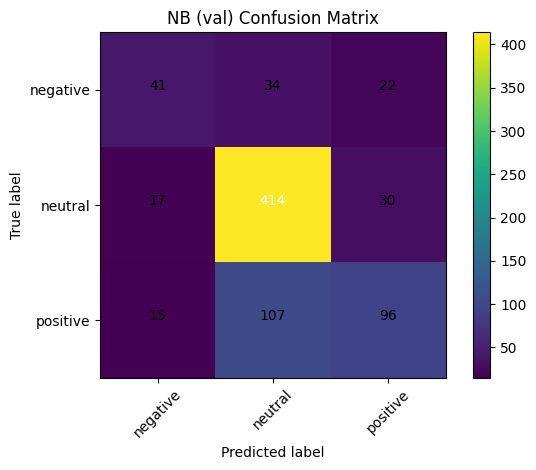

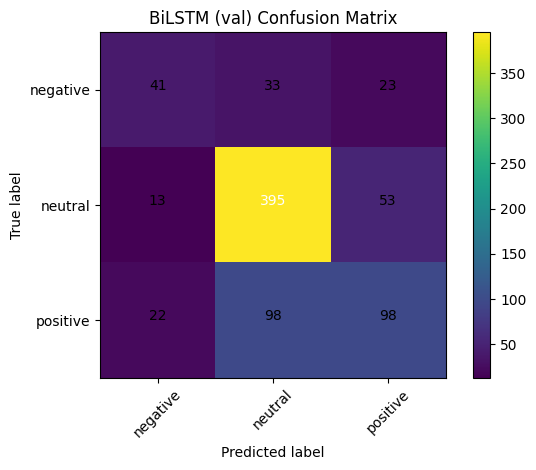

In [40]:

def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# NB CM (validation)
try:
    plot_cm(val_df["label_id"], pred_val, label_set, "NB (val) Confusion Matrix")
except Exception as e:
    print("NB CM skipped:", e)

# BiLSTM CM (validation)
try:
    if 'bilstm_val_pred' in globals():
        plot_cm(val_df["label_id"], bilstm_val_pred, label_set, "BiLSTM (val) Confusion Matrix")
except Exception as e:
    print("BiLSTM CM skipped:", e)


## 10. Apply Best Model to New Headlines

In [41]:

def predict_with_nb(texts):
    probs = tfidf_nb.predict_proba(texts)
    preds = tfidf_nb.predict(texts)
    return preds, probs

def demo_application():
    path = OUT_DIR / "scraped_headlines.csv"
    if path.exists():
        df_new = pd.read_csv(path)
        texts = df_new["title"].astype(str).tolist()
    else:
        texts = [
            "Tesla shares jump as deliveries beat expectations",
            "Federal Reserve signals rates may stay higher for longer",
            "Company Z misses revenue estimates; outlook trimmed"
        ]
        df_new = pd.DataFrame({"title": texts})
    preds, probs = predict_with_nb(texts)
    df_new["pred_id"] = preds
    df_new["pred_label"] = [id2label[i] for i in preds]
    # map probabilities to labels
    label_order = tfidf_nb.named_steps["clf"].classes_
    df_prob = pd.DataFrame(probs, columns=[id2label[i] for i in label_order])
    df_out = pd.concat([df_new, df_prob], axis=1)
    return df_out

df_app = demo_application()
df_app.head()


,source,ticker,title,url,pred_id,pred_label,negative,neutral,positive
0,google_news,AAPL,What Will Drive Apple Stock’s Next Big Move? -...,https://news.google.com/rss/articles/CBMiowFBV...,1,neutral,0.080190,0.671182,0.248629
1,google_news,AAPL,"After Earnings, Is Apple Stock a Buy, a Sell, ...",https://news.google.com/rss/articles/CBMilwFBV...,1,neutral,0.046418,0.786248,0.167334
2,google_news,AAPL,A Look at Apple (AAPL) Valuation After Recent ...,https://news.google.com/rss/articles/CBMivAFBV...,2,positive,0.078550,0.378049,0.543400
3,google_news,AAPL,What Could Spark the Apple Stock's Next Big Mo...,https://news.google.com/rss/articles/CBMiugFBV...,1,neutral,0.085475,0.730847,0.183678
4,google_news,AAPL,Can Apple Shares Surge Past $300 This Year? - ...,https://news.google.com/rss/articles/CBMijgFBV...,2,positive,0.156052,0.301462,0.542486


## 11. Save Artifacts

In [42]:

train_df.to_csv(OUT_DIR / "train.csv", index=False)
val_df.to_csv(OUT_DIR / "val.csv", index=False)
test_df.to_csv(OUT_DIR / "test.csv", index=False)

try:
    import joblib
    joblib.dump(tfidf_nb, OUT_DIR / "tfidf_nb.joblib")
except Exception as e:
    print("Model save skipped:", e)

print("Artifacts saved to ./outputs")


Artifacts saved to ./outputs



## 12. Notes on Customization & Justification

- **Preprocessing**: Light normalization preserves finance symbols ($, %, -) that carry meaning.
- **Imbalance**: Use class weights (deep models) or resampling. Track **macro F1**.
- **Model choices**:
  - **TF‑IDF + NB**: fast/strong for short texts.
  - **BiLSTM**: captures limited order/negation.
  - **FinBERT**: domain-specific; often best if compute allows.
- **Optimization**:
  - NB: tune `alpha`, `ngram_range`.
  - BiLSTM: embedding dim, LSTM units, dropout, LR, epochs.
  - Transformers: LR (1e‑5~5e‑5), batch (8–32), epochs (2–5), max length.
- **Evaluation**:
  - Prefer **macro F1** and per-class F1; add confusion matrices.
  - Consider **time‑based split** when mixing old vs. recent news.
- **Error analysis**:
  - Inspect false positives/negatives; build keyword sanity lists (“beat”, “miss”, “downgrade”, “upgrade”).
- **Reproducibility**:
  - Fix seeds; save artifacts; export versions.
